In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import paramnormal
# import seaborn as sns
# from statsmodels import api
from scipy import stats
from scipy.optimize import minimize 
import json
# import pprint


In [2]:
# This function cleans the data and creates c_0, c_f, and log_c_f

def cleanData(df):
    # Remove unnecessary columns
    df = df.drop('Link', axis=1)
    df = df.dropna()
    #df = df[df['Cited by'] >= 0]
    c_0_list = []

    # Calc c_0
    c_0 = {year : df.loc[df['Year'] == year, 'Cited by'].mean() for year in range(2001,2020)}

    for index, row in df.iterrows():
        c_0_list.append(c_0[row['Year']])
        #df['c_0'][index] = c_0[row['Year']]
    df['c_0'] = c_0_list
    # Calc c_f
    df['c_f'] = df['Cited by'] / df['c_0']
    df['c_f'].astype(np.float64)
    
    df['log_c_f'] = np.log(df['c_f'])
    df = df[df['c_f'] >= 0.1]


    return df


In [3]:
# Load data sets

ai_ml = pd.read_csv('AI_ML.csv')
col_sys = pd.read_csv('Swarming_MultiAgent.csv')
com_net = pd.read_csv('Communications_Networking.csv')
cont_alg = pd.read_csv('ControlSystems_Algorithms.csv')
cyb_sec = pd.read_csv('CyberSecurity.csv')
edg_com = pd.read_csv('EdgeComputing.csv')
ene_mgm = pd.read_csv('EnergyManagement.csv')
eth_reg = pd.read_csv('EthicsRegulations.csv')
hum_man = pd.read_csv('HumanMachineInteraction.csv')
loc_map = pd.read_csv('Localization_mapping.csv')
sen_fus = pd.read_csv('sensor_fusion.csv')
sen_tec = pd.read_csv('sensor_technology.csv')
sim_mod = pd.read_csv('Simulation_Modeling.csv')
tec_mob = pd.read_csv('Robotics.csv')


dataSets = [ai_ml, col_sys, com_net, cont_alg, cyb_sec, edg_com, ene_mgm, eth_reg, hum_man, loc_map, sen_fus, sen_tec, sim_mod, tec_mob]
keyNames = ["ai_ml", "col_sys", "com_net", "cont_alg", "cyb_sec", "edg_com", "ene_mgm", "eth_reg", "hum_man", "loc_map", "sen_fus", "sen_tec", "sim_mod", "tec_mob"]
fullNames = ["AI & Machine Learning", "Collaborative systems", "Communications & Networking", "Control systems & Algorithms", "Cybersecurity", "Edge Computing", "Energy Management", "Ethics & Regulations", "Human Machine Interaction", "Localization & Mapping", "Sensor Fusion", "Sensor Technologies", "Simulation & Modeling", "Technologies enabling mobility"]


In [4]:
def MLE(dataSets):    
    dist = stats.lognorm
    bounds = {
        'loc': (0,1),
        's': (0,2),
        'scale': (0,2)
    }
    #bounds = [(0,2), (0,1), (0,5)]
    parameterDict = {}
    bins = 50

    for index, df in enumerate(dataSets):
        df = cleanData(df)
        vals = df['c_f'].values.tolist()
        #res = paramnormal.lognormal.fit(vals)
        res = stats.fit(dist, vals, bounds=bounds, method='mle')
        
        parameterDict.update({keyNames[index]: {'mu': res.params.loc}})
        parameterDict[keyNames[index]].update({'sigma': res.params.s})
        parameterDict[keyNames[index]].update({'scale': res.params.scale})
        
    return parameterDict

In [5]:
# Perform the estimation
parameters = MLE(dataSets)

/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)
/opt/homebrew/anaconda3/envs/exjobb/lib

In [6]:
parameters

{'ai_ml': {'mu': 0.09418465946497345,
  'sigma': 1.5127187782197007,
  'scale': 0.4150937564411674},
 'col_sys': {'mu': 0.09507385350464204,
  'sigma': 1.4874907677169023,
  'scale': 0.4367101007335492},
 'com_net': {'mu': 0.09721678843565568,
  'sigma': 1.699723495135954,
  'scale': 0.3474299821114586},
 'cont_alg': {'mu': 0.09492086524426241,
  'sigma': 1.5343475879712614,
  'scale': 0.39824398151463436},
 'cyb_sec': {'mu': 0.09579312982445227,
  'sigma': 1.569648861708566,
  'scale': 0.3885957591935711},
 'edg_com': {'mu': 0.09287572158840363,
  'sigma': 1.659290819761909,
  'scale': 0.36544047912054367},
 'ene_mgm': {'mu': 0.10004132615858086,
  'sigma': 1.469923038251054,
  'scale': 0.4421848231743135},
 'eth_reg': {'mu': 0.09601642974006486,
  'sigma': 1.4088207336648575,
  'scale': 0.4899795643736946},
 'hum_man': {'mu': 0.10668485113856709,
  'sigma': 1.6027448431282307,
  'scale': 0.4172982417046583},
 'loc_map': {'mu': 0.09096269199995016,
  'sigma': 1.5358476291634549,
  'sc

In [7]:
with open("distribution_params.json", "w") as write_file:
    json.dump(parameters, write_file, indent=4)

In [8]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times new roman"]

In [9]:
def chi_test(dataSets):

    res_dict = {}

    for index, df in enumerate(dataSets):
        mu = parameters[keyNames[index]]["mu"]
        sigma = parameters[keyNames[index]]["sigma"]
        scale = parameters[keyNames[index]]["scale"]
        bin_edges = np.logspace(-1,2,20)
        df = cleanData(df)
        vals = df['c_f'].values.tolist()
        hist = plt.hist(vals, density=True, bins=bin_edges)

        dist = stats.lognorm(loc=mu, s = sigma, scale=scale)
        hist = plt.hist(vals, bins=bin_edges, density=True)
        x = bin_edges
        p = dist.pdf(x[1:len(x)])
        observed = np.array(hist[0])
        expected = np.array(p)

        epsilon = 1e-20
        df = 1

        if len(observed) == len(expected):
            chi_squared_stat = (((observed - expected)**2) / (expected + epsilon)).sum()
            crit = stats.chi2.ppf(q=0.95, df=df)
            pvalue = 1 - stats.chi2.cdf(x = chi_squared_stat, df = df)

            res_dict.update({keyNames[index]: {'chi_stat': chi_squared_stat, 'crit_value': crit, 'pvalue': pvalue}})
        else:
            print("obs and exp is not the same length", len(observed), len(expected))

        
    return res_dict
    

/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/a

,chi_stat,crit_value,pvalue
ai_ml,0.22,3.84,0.64
col_sys,0.32,3.84,0.57
com_net,0.46,3.84,0.50
cont_alg,0.23,3.84,0.63
cyb_sec,0.23,3.84,0.63
edg_com,0.43,3.84,0.51
ene_mgm,0.56,3.84,0.46
eth_reg,0.22,3.84,0.64
hum_man,0.27,3.84,0.60
loc_map,0.31,3.84,0.58


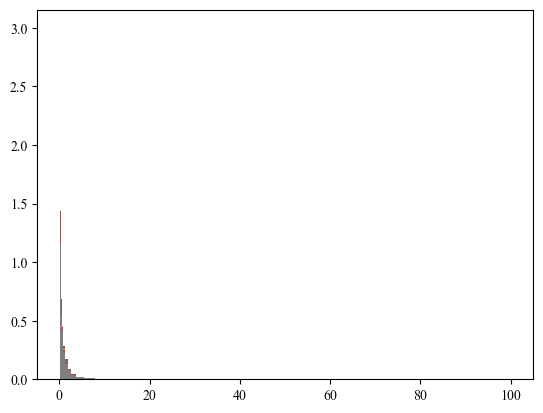

In [10]:
chi_results = chi_test(dataSets)
chi_df = pd.DataFrame(chi_results).T.round(2)
chi_df



In [11]:
def plot_hist2(dataSets, parameters=parameters, keyNames=keyNames):
    dist = stats.lognorm
    bounds = {
        'loc': (0,1),
        's': (0,2),
        'scale': (0,2)
    }

    bin_edges = np.logspace(-1,2,20)

    fig, axs = plt.subplots(5, 3, figsize=(10,12))
    axs = axs.ravel()

    for index, df in enumerate(dataSets):
        df = cleanData(df)
        vals = df['c_f'].values.tolist()
        
        axs[index].hist(vals, bins=bin_edges, density=True, color='dimgray')
        
        mu = parameters[keyNames[index]]['mu']
        sigma = parameters[keyNames[index]]['sigma'] 
        scale = parameters[keyNames[index]]['scale'] 

        dist = stats.lognorm(loc=mu, s = sigma, scale=scale)
        p = dist.pdf(np.logspace(-0.95,2,20))
       
        axs[index].plot(bin_edges, p, color='gold')
        axs[index].set_xscale('log')
        axs[index].set_yscale('log')
        axs[index].set_title(fullNames[index])
        axs[index].set_xlabel("$c_f$", math_fontfamily='cm')

        # only set ylabel for subplots on the left
        if index % 3 == 0:
            axs[index].set_ylabel("$f$", math_fontfamily='cm')
        else:
            axs[index].set_ylabel('') # set an empty string to remove ylabel for subplots on the right

    plt.tight_layout()
    plt.savefig('researchprogress_dists_hist.pdf', format='pdf')  
    plt.show()


In [12]:
def plot_hist2(dataSets, parameters=parameters, keyNames=keyNames):
    dist = stats.lognorm
    bounds = {
        'loc': (0,1),
        's': (0,2),
        'scale': (0,2)
    }

    bin_edges = np.logspace(-1,2,20)

    fig, axs = plt.subplots(5, 3, figsize=(9/1.25,12/1.25))
    axs = axs.ravel()

    for index, df in enumerate(dataSets):
        df = cleanData(df)
        vals = df['c_f'].values.tolist()
        
        axs[index].hist(vals, bins=bin_edges, density=True, color='dimgray')
        
        mu = parameters[keyNames[index]]['mu']
        sigma = parameters[keyNames[index]]['sigma'] 
        scale = parameters[keyNames[index]]['scale'] 

        dist = stats.lognorm(loc=mu, s = sigma, scale=scale)
        p = dist.pdf(np.logspace(-0.95,2,20))
       
        axs[index].plot(bin_edges, p, color='gold')
        axs[index].set_xscale('log')
        axs[index].set_yscale('log')
        axs[index].set_title(fullNames[index])
        axs[index].set_xlabel("$c_f$", math_fontfamily='cm')

        # only set ylabel for subplots on the left
        if index % 3 == 0:
            axs[index].set_ylabel("$f$", math_fontfamily='cm')
        else:
            axs[index].set_ylabel('') # set an empty string to remove ylabel for subplots on the right

    plt.tight_layout()
    plt.savefig('researchprogress_dists_hist.pdf', format='pdf')  
    plt.show()


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/a

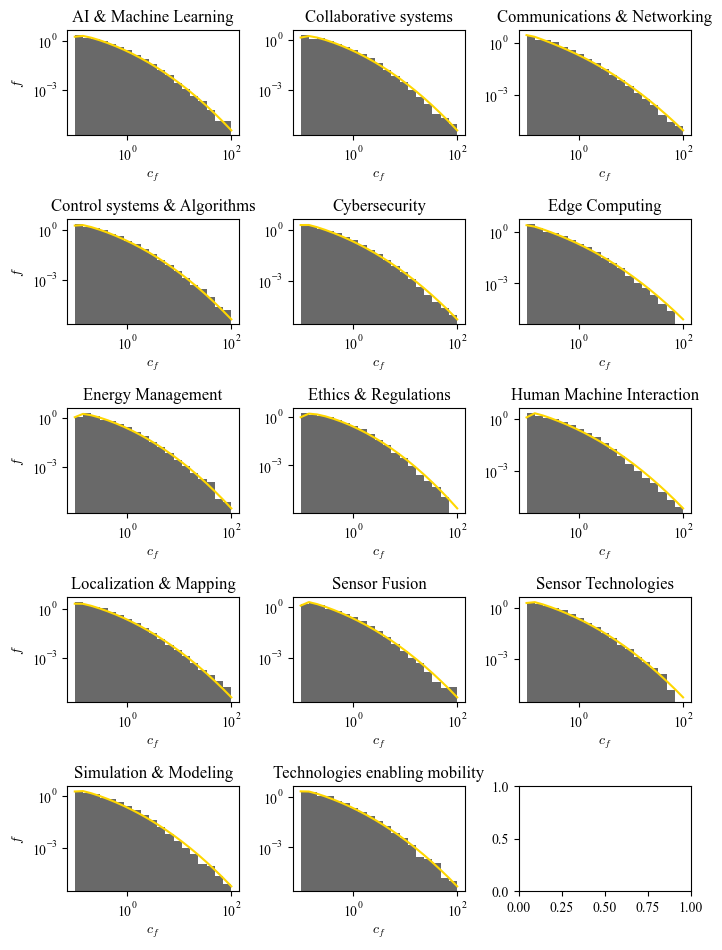

<Figure size 640x480 with 0 Axes>

In [13]:
plot_hist2(dataSets, parameters)
plt.savefig('researchprogress_dists.pdf')  


In [66]:


def plot_all_pdfs(dataSets, parameters=parameters, keyNames=keyNames):
    bin_edges = np.logspace(0,2,20)
    bin_edges2 = np.logspace(-0.1,2.1,20)

    fig, ax = plt.subplots()

    markers = ['o', 's', '^', 'v', '*', 'x', 'D', 'p', 'h', '+', '>', '<', 'd', '|']

    mu_list = []
    sigma_list = []
    scale_list = []

    for index, df in enumerate(dataSets):
        mu = parameters[keyNames[index]]['mu']
        sigma = parameters[keyNames[index]]['sigma']
        scale = parameters[keyNames[index]]['scale']

        mu_list.append(mu)
        sigma_list.append(sigma)
        scale_list.append(scale)

        dist = stats.lognorm(loc=mu, s=sigma, scale=scale)
        p = dist.pdf(bin_edges)

        marker = markers[index % len(markers)]
        plt.plot(bin_edges, p, marker=marker)
        plt.xscale('log')
        plt.yscale('log')

    dist = stats.lognorm(loc=np.average(mu_list), s=np.average(sigma_list), scale=np.average(scale_list))
    p = dist.pdf(bin_edges2)
    # Add a legend for the dashed line
    mu_dash = np.average(mu_list)
    sigma_dash = np.average(sigma_list)
    legend_text = f'$\mu=${mu_dash.round(2)}, \n$\sigma=${sigma_dash.round(2)}'
    #legend1 = plt.legend([legend_text], loc='upper right')
    plt.plot(bin_edges2, p, linestyle='dashed', color='black')

    ax.legend(fullNames, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig('researchprogress_dists_lines.pdf', format='pdf', bbox_inches="tight")  
    plt.show()


In [109]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot_all_pdfs(dataSets, parameters=parameters, keyNames=keyNames):
    bin_edges = np.logspace(0,2,20)
    bin_edges2 = np.logspace(-0.1,2.1,20)

    fig, ax = plt.subplots()

    markers = ['o', 's', '^', 'v', '*', 'x', 'D', 'p', 'h', '+', '>', '<', 'd', '|']

    mu_list = []
    sigma_list = []
    scale_list = []

    for index, df in enumerate(dataSets):
        mu = parameters[keyNames[index]]['mu']
        sigma = parameters[keyNames[index]]['sigma']
        scale = parameters[keyNames[index]]['scale']

        mu_list.append(mu)
        sigma_list.append(sigma)
        scale_list.append(scale)

        dist = stats.lognorm(loc=mu, s=sigma, scale=scale)
        p = dist.pdf(bin_edges)

        marker = markers[index % len(markers)]
        plt.plot(bin_edges, p, marker=marker)
        plt.xscale('log')
        plt.yscale('log')

    dist = stats.lognorm(loc=np.average(mu_list), s=np.average(sigma_list), scale=np.average(scale_list))
    p = dist.pdf(bin_edges2)
    plt.plot(bin_edges2, p, linestyle='dashed', color='black')

    # Add a legend for the dashed line
    mu_dash = np.average(mu_list)
    sigma_dash = np.average(sigma_list)
    legend_text = f'Dashed line: \n $\mu=${mu_dash.round(2)}  \n$\sigma=${sigma_dash.round(2)}'
    ax.annotate(legend_text, xy=(0.9, 0.9), xycoords='axes fraction', ha='right', va='top', math_fontfamily='cm')
    

    ax.legend(fullNames, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.savefig('researchprogress_dists_lines.pdf', format='pdf', bbox_inches="tight")  
    plt.show()


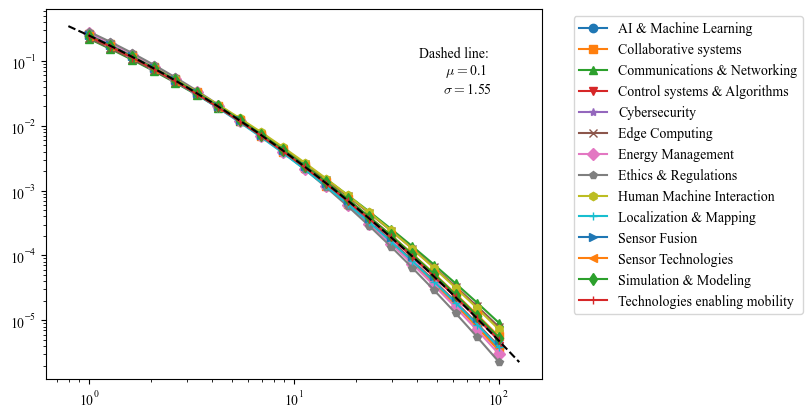

In [110]:
plot_all_pdfs(dataSets, parameters)

In [16]:
def test_fit_ks(dataSets, parameters=parameters, keyNames=keyNames):
    bin_edges = np.logspace(0,3,20)
    res_dict = {}
    for index, df in enumerate(dataSets):
        df = cleanData(df)
        vals = df['c_f'].values.tolist()

        mu = parameters[keyNames[index]]["mu"]
        sigma = parameters[keyNames[index]]["sigma"]
        scale = parameters[keyNames[index]]["scale"]
        dist = stats.lognorm(loc=mu, s = sigma, scale=scale)
        hist = plt.hist(vals, bins=bin_edges, density=True)
        x = bin_edges
        p = dist.pdf(x)
        obs = np.array(hist[0])
        exp = np.array(p)

        print(len(obs), len(exp))
        
        # Kolmogorov-Smirnov test
        res = stats.ks_2samp(obs, exp)
        #res = stats.ks_1samp(obs, stats.lognorm.cdf(np.logspace(-1,2,20), s=sigma))

        res_dict.update({keyNames[index]: {'pvalue': res[1]}})
        res_dict[keyNames[index]].update({'statistic': res[0]})

        print(res)
    
    return res_dict

    
        

/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.3157894736842105, pvalue=0.23542424272704296, statistic_location=0.0, statistic_sign=1)


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.2631578947368421, pvalue=0.43375177374306845, statistic_location=0.0, statistic_sign=1)
19 20
KstestResult(statistic=0.3157894736842105, pvalue=0.23542424272704296, statistic_location=0.0, statistic_sign=1)


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.2631578947368421, pvalue=0.43375177374306845, statistic_location=0.0, statistic_sign=1)


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.2631578947368421, pvalue=0.43375177374306845, statistic_location=0.0, statistic_sign=1)
19 20
KstestResult(statistic=0.3684210526315789, pvalue=0.11347310564798593, statistic_location=0.0, statistic_sign=1)
19 20
KstestResult(statistic=0.3157894736842105, pvalue=0.23542424272704296, statistic_location=0.0, statistic_sign=1)


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.3157894736842105, pvalue=0.23542424272704296, statistic_location=0.0, statistic_sign=1)
19 20
KstestResult(statistic=0.3157894736842105, pvalue=0.23542424272704296, statistic_location=0.0, statistic_sign=1)


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.21052631578947367, pvalue=0.6960843302575662, statistic_location=0.0, statistic_sign=1)


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


19 20
KstestResult(statistic=0.3157894736842105, pvalue=0.23542424272704296, statistic_location=0.0, statistic_sign=1)
19 20
KstestResult(statistic=0.3157894736842105, pvalue=0.23542424272704296, statistic_location=0.0, statistic_sign=1)
19 20
KstestResult(statistic=0.2631578947368421, pvalue=0.43375177374306845, statistic_location=0.0, statistic_sign=1)
19 20
KstestResult(statistic=0.3157894736842105, pvalue=0.23542424272704296, statistic_location=0.0, statistic_sign=1)


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


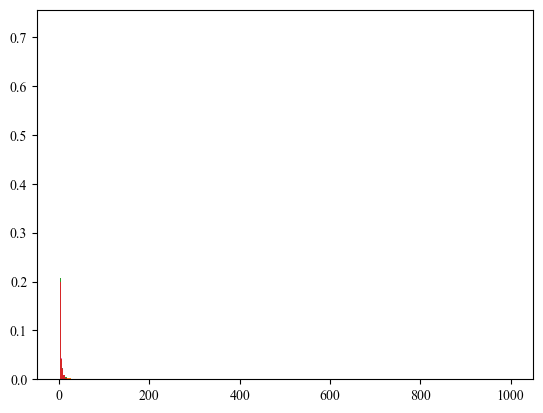

In [17]:
fit_results = test_fit_ks(dataSets)


In [18]:
c_0_list = []
c_max_list = []
c_f_max_list = []
for index, df in enumerate(dataSets):
    df = cleanData(df)
    c_0_list.append(df['Cited by'].mean())
    c_max_list.append(df['Cited by'].max())
    c_f_max_list.append(df['c_f'].max())

df = pd.DataFrame(parameters).T[['mu', 'sigma']]

df['c_0'] = c_0_list
df['c_max'] = c_max_list
df['c_f_max'] = c_f_max_list


df2 = pd.DataFrame(fit_results).T[['pvalue']]
df2 = df2.rename(columns={'pvalue': 'pvalue_ks'})
df = df.join([df2, chi_df['pvalue']])
df = df.rename(columns={'pvalue': 'pvalue_chi2'})
df = df.round(2)


df.index = fullNames
print(df)
df.to_excel('output.xlsx')

/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/a

                                  mu  sigma    c_0  c_max  c_f_max  pvalue_ks  \
AI & Machine Learning           0.09   1.51  29.37   3149    96.32       0.24   
Collaborative systems           0.10   1.49  26.90   2811   143.65       0.43   
Communications & Networking     0.10   1.70  29.58   3149    97.56       0.24   
Control systems & Algorithms    0.09   1.53  22.84   2479   124.31       0.43   
Cybersecurity                   0.10   1.57  23.11   5145   249.68       0.43   
Edge Computing                  0.09   1.66  48.72   7208    61.04       0.11   
Energy Management               0.10   1.47  33.70   1868    89.17       0.24   
Ethics & Regulations            0.10   1.41  30.06   2479   122.37       0.24   
Human Machine Interaction       0.11   1.60  23.89   2093   102.17       0.24   
Localization & Mapping          0.09   1.54  34.13   7208   195.37       0.70   
Sensor Fusion                   0.10   1.55  29.12   2680   105.91       0.24   
Sensor Technologies         

/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
ai_ml['Cited by'].max()

3149